In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

SAMPLE AT INDEX 0
LABEL: 5


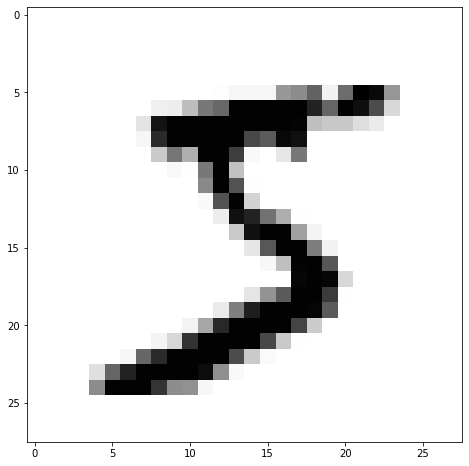

In [ ]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [ ]:
class ImageDataset(Dataset):

  def __init__(self, dataset, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    # Get x and y values from each line and append to self.data

    self.data = []
    to_tensor = torchvision.transforms.ToTensor()
    for d in dataset:
      image = d[0]
      label = d[1]
      image = to_tensor(image)
      label = torch.tensor(label).long()
      self.data.append((image, label))

    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [ ]:
def calculate_accuracy(predictions, labels, sample_size):
  return (predictions == labels).int().sum().item() / sample_size

In [ ]:
def get_prediction(output):
  sig = nn.Sigmoid()
  prediction = torch.argmax(sig(output), dim=1)
  return prediction

In [ ]:
torch.manual_seed(0)
composed_transform = None#transforms.Compose([])

train_size = int(len(train_dataset) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_dataset))

full_dataset = ImageDataset(train_dataset, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_dataset, transform=composed_transform) #Test Dataset

In [ ]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

# Model Definition

Implemented LeNet5 a state of the art network for digit classification with addition of dropout layers

In [ ]:
class DigitNet(nn.Module):
    
    def __init__(self, drop1 = 0.25, drop2 = 0.25, drop3 = 0.7):
        super().__init__()
        
        self.c1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=1, padding=2)
        torch.nn.init.kaiming_uniform_(self.c1.weight, nonlinearity='relu')
        self.s2 = nn.AvgPool2d(kernel_size=(2,2), stride = 2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=1)
        torch.nn.init.kaiming_uniform_(self.c3.weight, nonlinearity='relu')
        self.s4 = nn.AvgPool2d(kernel_size=(2,2), stride = 2)
        self.c5 = nn.Conv2d(16, 120, kernel_size=(5, 5), stride=1)
        torch.nn.init.kaiming_uniform_(self.c5.weight, nonlinearity='relu')
        self.f6 = nn.Linear(120, 84)
        torch.nn.init.kaiming_uniform_(self.f6.weight, nonlinearity='relu')
        self.out = nn.Linear(84, 10)
        self.act = nn.ReLU()
       
        self.drop1 = nn.Dropout(p = drop1)
        self.drop2 = nn.Dropout(p = drop2)
        self.drop3 = nn.Dropout(p = drop3)
        print('Network initialized')
        
    def forward(self, x):
        x = self.act(self.c1(x)) #conv layer
        x = self.drop1(x) #dropout
        x = self.s2(x) #pooling
        x = self.act(self.c3(x)) #conv
        x = self.drop2(x) #dropout
        x = self.s4(x) #pooling
        x = self.act(self.c5(x)) #conv
        x = x.reshape(x.shape[0], -1)
        x = self.act(self.f6(x)) #flatten
        x = self.drop3(x)
        x = self.out(x) #output
        return x

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


**Model initialization**

In [ ]:
torch.manual_seed(0)
net = DigitNet()
net = net.to(device)

Network initialized


# Loss Definition

In [ ]:
loss_function = nn.CrossEntropyLoss()

# Optimizer Definition

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training Loop

In [ ]:
def train_model(net, loss_function, optimizer, num_epochs, train_dataloader, val_dataloader, verbose=True):
  print(net)
  train_accuracy_log = []
  val_accuracy_log = []
  for epoch_num in range(num_epochs):
    if verbose:
      print('#################')
      print(f'# EPOCH {epoch_num}')
      print('#################')

    ### TRAIN
    train_pred = []
    
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
      # Move data to device
      x_train = sample_batched[0].to(device)
      labels_train = sample_batched[1].to(device)
      #print(x_train.shape)
      # Forward pass
      out = net(x_train)
    
      # Compute loss
      loss = loss_function(out, labels_train)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      #Compute predictions
      predictions = get_prediction(out)
      train_predicted = calculate_accuracy(predictions, labels_train, x_train.shape[0])

      # Save train loss for this batch
      train_pred.append(train_predicted)

    # Save average train loss
    train_pred = np.mean(train_pred)
    if verbose:
      print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
    train_accuracy_log.append(train_pred)

    ### VALIDATION
    val_pred = []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
      for sample_batched in val_dataloader: #should be validation dataloader
        # Move data to device
        x_val = sample_batched[0].to(device)
        labels_val = sample_batched[1].to(device)

        # Forward pass
        output = net(x_val)
        
        #Compute predictions
        prediction = get_prediction(output)
        val_predicted = calculate_accuracy(prediction, labels_val, x_val.shape[0])

        # Save val loss for this batch
        val_pred.append(val_predicted)


      # Save average validation loss
      val_pred = np.mean(val_pred)
      if verbose:
        print(f"AVERAGE VAL ACCURACY: {val_pred * 100}%")
      val_accuracy_log.append(val_pred)
  print(f"Models validation accuracy: {val_accuracy_log[-1]}")
  return train_accuracy_log, val_accuracy_log

In [ ]:
 train_accuracy_log, val_accuracy_log = train_model(net, loss_function, optimizer, 10, train_dataloader, val_dataloader, False)

DigitNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (drop3): Dropout(p=0.7, inplace=False)
)
Models validation accuracy: 0.9881666666666666


Grid Search

In [ ]:
dropout_params1 = [0.1, 0.2, .3, .4, .5, .6, .7, .8, .9]
dropout_params2 = [0.1, 0.2, .3, .4, .5, .6, .7, .8, .9]
dropout_params3 = [0.1, 0.2, .3, .4, .5, .6, .7, .8, .9]
learning_rates = [0.1, 0.01, 0.001]
max_accuracy = 0
best_drop1 = 0.1
best_drop2 = 0.1
best_drop3 = 0.1
best_learning_rate = 0.001
for drop1 in dropout_params1:
  for drop2 in dropout_params2:
    for drop3 in dropout_params3:
      #for lr in learning_rates:
      lr = 0.001
      print(f"Checking with drop1: {drop1} drop2: {drop2} drop3: {drop3} lr: {lr}")
      net = DigitNet(drop1, drop2, drop3).to(device)
      optimizer = optim.Adam(net.parameters(), lr=lr)
      train_accuracy_log, val_accuracy_log = train_model(net, loss_function, optimizer, 10, train_dataloader, val_dataloader, False)
      val_accu = val_accuracy_log[-1]
      if val_accu > max_accuracy:
        max_accuracy = val_accu
        best_drop1 = drop1
        best_drop2 = drop2
        best_drop3 = drop3
        best_learning_rate = lr
        print(f"BETTER MODEL ACHIEVED WITH drop1: {drop1} drop2: {drop2} drop3: {drop3} lr: {lr}")

print(f"THE BEST MODEL IS ACHIEVED WITH drop1: {best_drop1} drop2: {best_drop2} drop3: {best_drop3} lr: {best_learning_rate}")

Checking with drop1: 0.1 drop2: 0.1 drop3: 0.1 lr: 0.001
Network initialized
DigitNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.1, inplace=False)
  (drop3): Dropout(p=0.1, inplace=False)
)
Models validation accuracy: 0.98975
BETTER MODEL ACHIEVED WITH drop1: 0.1 drop2: 0.1 drop3: 0.1 lr: 0.001
Checking with drop1: 0.1 drop2: 0.1 drop3: 0.2 lr: 0.001
Network initialized
DigitNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c3): Conv2d(6, 16, 

# Training plot 

In [ ]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train loss')
plt.semilogy(val_accuracy_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Generalization error estimation

In [ ]:
test_predictions = []
sig = nn.Sigmoid()
net.eval()
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader: 
      # Move data to device
      x_test = sample_batched[0].to(device)
     
      #print(total_images)
      labels_test = sample_batched[1].to(device)
      
      # Forward pass
      output = net(x_test)
    
      # Compute prediction
      prediction = get_prediction(output)
      correct_predictions = calculate_accuracy(prediction, labels_test, x_test.shape[0])
      
      # Save val prediction for this batch
      test_predictions.append(correct_predictions)
      
      
    # Save average validation loss
    test_predictions = np.mean(test_predictions)
    print(f"AVERAGE ACCURACY: {test_predictions * 100}%")

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(prediction.cpu().numpy(), labels_test.cpu().numpy())

In [ ]:
# First hidden layer
c1_w = net.c1.weight.data.cpu().numpy()
c1_b = net.c1.bias.data.cpu().numpy()

# Second hidden layer
c3_w = net.c3.weight.data.cpu().numpy()
c3_b = net.c3.bias.data.cpu().numpy()


c5_w = net.c5.weight.data.cpu().numpy()
c5_b = net.c5.bias.data.cpu().numpy()

f6_w = net.f6.weight.data.cpu().numpy()
f6_b = net.f6.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

In [ ]:
# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(c3_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(c5_w.flatten(), 50)
axs[2].set_title('Third layer weights')
axs[3].hist(f6_w.flatten(), 50)
axs[3].set_title('Forth layer weights')
axs[4].hist(out_w.flatten(), 50)
axs[4].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
net_state_dict = net.state_dict()
# Save the state dict to a file
#the best model is saved in net_parameters.torch
torch.save(net_state_dict, 'net_parameters_test.torch')

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)
    

### Register hook  
#We want to inspect the neurons values of the second layer given a specific input in order to show which neuron will fire
hook_handle = net.out.register_forward_hook(get_activation) #It's called whenever a forward step is done. 
#When forward phase is completed, hook is called, the activation function used is called and is stored in order to
#vizualize the activated neurons of a specific layer

### Analyze activations
little_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
for batch in little_dataloader:
  images = batch[0]
  labels = batch[1]
  x1 = images[0]
  label1 = labels[0]
  x1 = x1.unsqueeze(0).to(device)
  x2 = images[1]
  label2 = labels[1]
  x2 = x2.unsqueeze(0).to(device)
  x3 = images[2]
  label3 = labels[2]
  x3 = x3.unsqueeze(0).to(device)
  break
net = net.to(device)
net.eval()
with torch.no_grad():
    #x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation 
    #x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    #x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Last layer activations for input x=%.2f' % label1)
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Last layer activations for input x=%.2f' % label2)
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Last layer activations for input x=%.2f' % label3)
plt.tight_layout()
plt.show()